# Forecasting NQH2O Prices Using CALFEWS


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.dates as mdates

Futures on the Nasdaq Veles California Water Index are available for trading through CME Group. Pricing Data download from [Nasdaq](https://indexes.nasdaqomx.com/Index/History/NQH2O). Weighting and industry breakdown needs subscription. 


Prices reflect the commodity value of water at the source and do not include additional costs associated with transportation or losses.
Water price data is:  
1. Aggregated from the five largest and most actively traded markets in California 
** central basin, chino basin, main san gabriel basin, mojave basin, surface water
2. Priced weekly in US$ per Acre Foot ($/AF)
3. Sourced weekly from Waterlitix™ – a pricing and market information database developed and maintained by WestWater Research
4. Data based on volume transacted across western market over past 10 yrs. Growth driven by expansion of high valued specialty crops in CA.

In [2]:
import os
print(os.getcwd())
os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
print(os.getcwd())


c:\Users\danli\OneDrive - University of North Carolina at Chapel Hill\github\CALFEWS
C:\Users\danli\OneDrive - University of North Carolina at Chapel Hill\github\CALFEWS


In [3]:
# Load historical data
NQH2O_hist = pd.read_excel('calfews_src/data/price_index/NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]

# Load additional data
NQH2O_pre = pd.read_csv('calfews_src/data/price_index/AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

# Combine and sort the data
combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df.reset_index(drop=True, inplace=True)

# Convert 'Date' to datetime format if not already done
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Create an empty column for 6-month forward average price
combined_df['6_Month_Forward_Avg'] = None

# Function to calculate the 6-month forward average
def calculate_6_month_forward_avg(current_date, df):
    # Define the date range 6 months forward
    
    end_date = current_date + pd.DateOffset(months=6)
    
    # Filter the dataframe for the date range
    mask = (df['Date'] >= current_date) & (df['Date'] <= end_date)
    relevant_prices = df.loc[mask, 'NQH2O']
    
    # Calculate the average
    if len(relevant_prices) > 0:
        return relevant_prices.mean()
    else:
        return None

# Apply the function to each row
combined_df['6_Month_Forward_Avg'] = combined_df['Date'].apply(lambda x: calculate_6_month_forward_avg(x, combined_df))

# Display the result
combined_df

,Date,NQH2O,6_Month_Forward_Avg
0,2013-01-09,222.02,244.881538
1,2013-01-16,146.89,246.209231
2,2013-01-23,113.34,250.956154
3,2013-01-30,109.68,257.455769
4,2013-02-06,109.77,264.173462
...,...,...,...
634,2024-09-25,431.69,431.690000
635,2024-09-26,431.69,431.690000
636,2024-09-27,431.69,431.690000
637,2024-09-30,431.69,431.690000


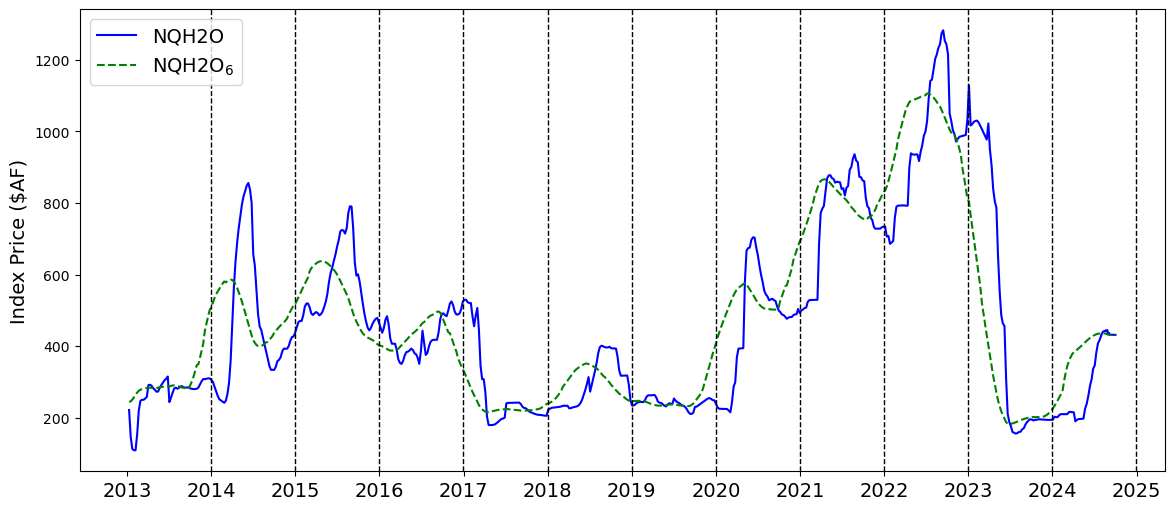

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['NQH2O'], label='Price over time', color='blue')
plt.plot(combined_df['Date'], combined_df['6_Month_Forward_Avg'], label='Price over time', linestyle='--',color='green')
# Adding vertical lines at the end of each year
for year in range(combined_df['Date'].dt.year.min(), combined_df['Date'].dt.year.max() + 1):
    plt.axvline(pd.Timestamp(f'{year}-12-31'), color='black', linestyle='--', linewidth=1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks()

plt.legend(['NQH2O', 'NQH2O$_{6}$'], fontsize=14)
plt.ylabel('Index Price ($AF)', fontsize=14)
# plt.legend(['NQH2O'])
plt.show()

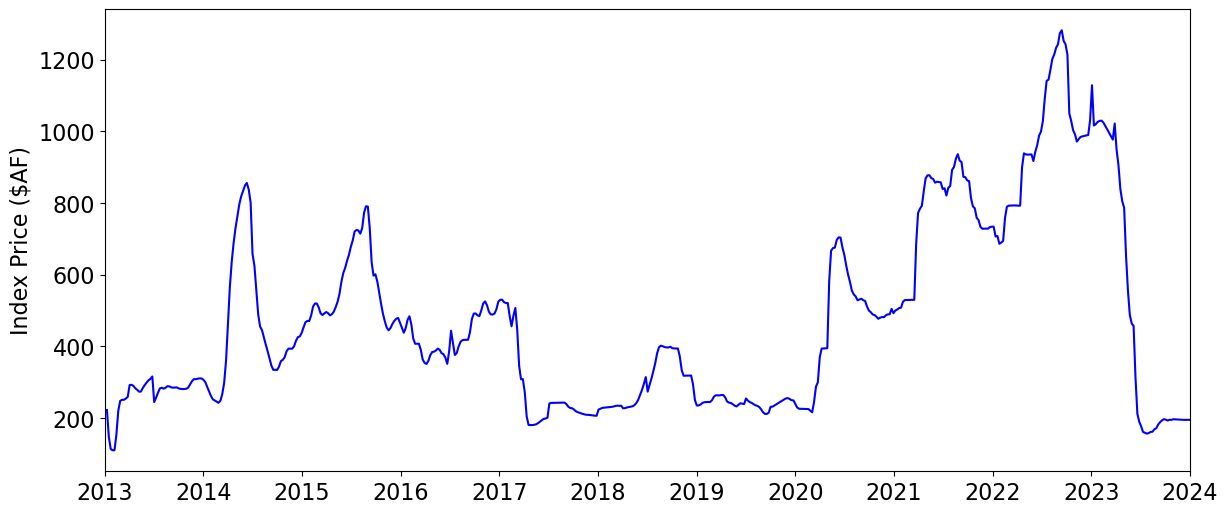

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['Date'], combined_df['NQH2O'], label='Price over time', color='blue')
# plt.plot(combined_df['Date'], combined_df['6_Month_Forward_Avg'], label='6 Month Forward Avg', linestyle='--', color='green')

# Adding vertical lines at the end of each year
# for year in range(combined_df['Date'].dt.year.min(), combined_df['Date'].dt.year.max() + 1):
#     # Shade the area from May to August
#     plt.axvspan(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-08-31'), color='gray', alpha=0.3)
#     plt.axvline(pd.Timestamp(f'{year}-12-31'), color='black', linestyle='--', linewidth=1)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2024-01-01'))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(['NQH2O', '6 Month Forward Avg'])
plt.ylabel('Index Price ($AF)', fontsize=16)
# plt.legend(['NQH2O'])
# plt.legend()
plt.show()

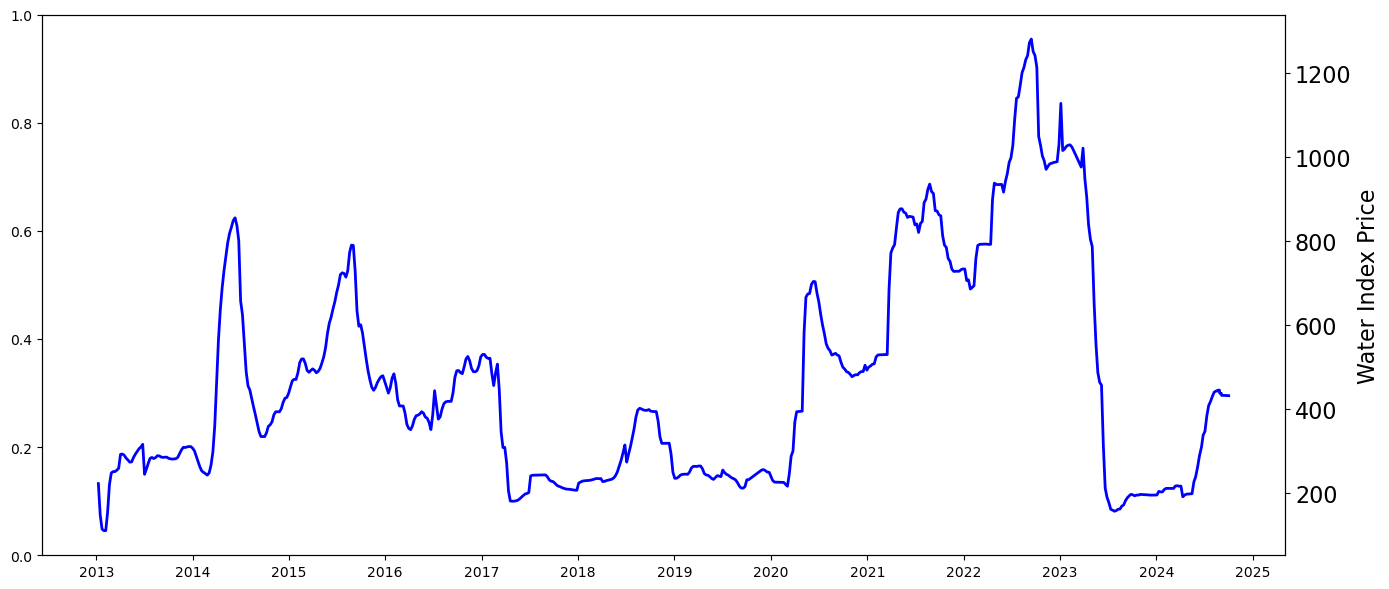

In [7]:
df = pd.read_csv('calfews_src/data/price_index/USDM-california.csv')
df['MapDate'] = pd.to_datetime(df['MapDate'], format='%Y%m%d')
df = df[df['MapDate'] >= '2013-01-01']
fig, ax1 = plt.subplots(figsize=(14, 6))

# # Plot the drought severity time series
# ax1.fill_between(df['MapDate'], df['D0'], color='lightyellow', label='D0 - Abnormally Dry')
# ax1.fill_between(df['MapDate'], df['D1'], df['D2'], color='bisque', label='D1 - Moderate Drought')
# ax1.fill_between(df['MapDate'], df['D2'], df['D3'], color='orange', label='D2 - Severe Drought')
# ax1.fill_between(df['MapDate'], df['D3'], df['D4'], color='darkorange', label='D3 - Extreme Drought')
# ax1.fill_between(df['MapDate'], df['D4'], color='red', label='D4 - Exceptional Drought')

# # ax1.set_xlabel('Date')
# ax1.set_ylabel('Percentage of Area in Drought (%)', fontsize=16)   
# ax1.set_title('Drought Severity and Index Price Time Series for CA (2013-Present)')
# ax1.legend(loc='upper left', fontsize=14)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.xaxis.set_tick_params(labelsize=16)
# plt.xticks(rotation=45)
# ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(combined_df['Date'], combined_df['NQH2O'],color='blue', label='NQH2O Index Price',linewidth=2)
ax2.set_ylabel('Water Index Price', fontsize=16)
# ax2.legend(loc='upper right', fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# Visualization of kern county water agency

In [ ]:
# pip install --upgrade pip setuptools wheel
# !pip install contextily  # python version does not match 

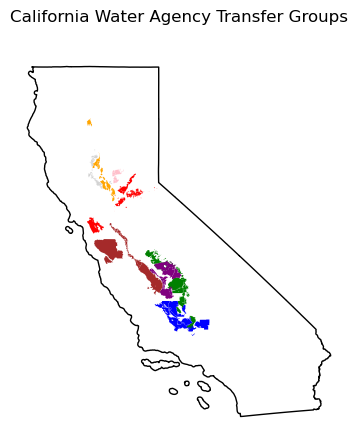

In [32]:
# read shapefile
import geopandas as gpd
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
shapefiles = [
    'TransferGroupsCA/Folsom Dam & Canal/Folsom Dam & Canal.shp',
    'TransferGroupsCA/Friant - Kern Canal/Friant - Kern Canal.shp',
     'TransferGroupsCA/Kern County Water Agency/Kern County Water Agency.shp',
    'TransferGroupsCA/Kings River Water Association/Kings River Water Association.shp',
    'TransferGroupsCA/Sacramento River Settlement/Sacramento River Settlement.shp',
    'TransferGroupsCA/San Luis and Delta-Mendota/San Luis and Delta-Mendota.shp',
    # 'TransferGroupsCA/State Water Project/State Water Project.shp',
    'TransferGroupsCA/Tehama - Colusa Canal/Tehama - Colusa Canal.shp',
    'TransferGroupsCA/Yuba Water Authority/Yuba Water Authority.shp',
  
]
us_states = gpd.read_file("TransferGroupsCA/tl_2024_us_state/tl_2024_us_state.shp")
california = us_states[us_states['STUSPS'] == 'CA']

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'lightgrey','pink','cyan']


california = california.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(5, 5))

california.boundary.plot(ax=ax, color='black', linewidth=1)

for shapefile, color in zip(shapefiles, colors):
    gdf = gpd.read_file(shapefile)
    gdf = gdf.to_crs(epsg=3857)  
    gdf.plot(ax=ax, color=color, label=os.path.basename(shapefile).split('.')[0])

ax.set_axis_off()
# ax.legend()
ax.set_title('California Water Agency Transfer Groups', pad=20)
plt.show()


# Watershed
HUC 8 is too detailed. Need HUC 4

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


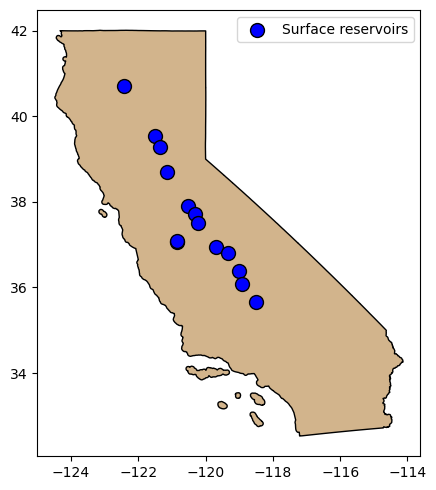

In [21]:
import geopandas as gpd
us_states = gpd.read_file("TransferGroupsCA/tl_2024_us_state/tl_2024_us_state.shp")
california = us_states[us_states['STUSPS'] == 'CA']

reservoirs_data = {
    'name': [
        'Shasta', 'Oroville', 'Yuba', 'Folsom', 'New Melones', 'Don Pedro', 'Exchequer',
        'San Luis State', 'San Luis Federal', 'Millerton', 'Pine Flat', 'Kaweah', 'Success', 'Isabella'
    ],
    'longitude': [
        -122.4194, -121.4927, -121.3542, -121.1511, -120.5232, -120.3102, -120.2363,
        -120.8537, -120.8602, -119.7053, -119.3485, -119.0158, -118.9085, -118.4925
    ],
    'latitude': [
        40.7178, 39.538, 39.2938, 38.7071, 37.9121, 37.7163, 37.5052,
        37.0625, 37.0831, 36.9544, 36.8111, 36.3901, 36.0783, 35.6548
    ]
}
reservoirs = pd.DataFrame(reservoirs_data)
reservoirs_gdf = gpd.GeoDataFrame(
    reservoirs,
    geometry=gpd.points_from_xy(reservoirs['longitude'], reservoirs['latitude']),
    crs='EPSG:4326'
)

california = california.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(8, 5))
california.plot(ax=ax, color='#D2B48C', edgecolor='black')  # Use hex code for light brown color
reservoirs_gdf.plot(ax=ax, color='blue', edgecolor='black', marker='o', markersize=100, label='Surface reservoirs')
# reservoirs_gdf[reservoirs_gdf['name'] == 'Shasta'].plot(ax=ax, color='red', edgecolor='black', marker='o', markersize=100, label='Shasta reservoir')
# reservoirs_gdf[reservoirs_gdf['name'] != 'Shasta'].plot(ax=ax, color='blue', edgecolor='black', marker='o', markersize=100, label = 'Major reservoirs')


# # Connect the reservoirs (assuming they are connected in the given order)
# for i in range(len(reservoirs_gdf) - 1):
#     x_coords = [reservoirs_gdf.geometry.iloc[i].x, reservoirs_gdf.geometry.iloc[i + 1].x]
#     y_coords = [reservoirs_gdf.geometry.iloc[i].y, reservoirs_gdf.geometry.iloc[i + 1].y]
#     ax.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=2)

# plt.title('California Map with Reservoirs and Connecting Rivers', fontsize=16, fontweight='bold')
plt.legend()
# plt.xlabel('Longitude', fontsize=12)
# plt.ylabel('Latitude', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


# Transfer data (Bulletin -132)

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
# current_directory
#read csv file
df_buyer = pd.read_csv('maxs_work/bulletin_132_work/transfers_by_buyer.csv')
df_seller = pd.read_csv('maxs_work/bulletin_132_work/transfers_by_seller.csv')
df_buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Buyer                 283 non-null    object 
 1   Available Water (AF)  283 non-null    int64  
 2   Carriage Losses (AF)  283 non-null    object 
 3   Delivered             283 non-null    int64  
 4   Year                  283 non-null    int64  
 5   Type                  283 non-null    object 
 6   Price ($/AF)          240 non-null    float64
 7   Group                 4 non-null      object 
 8   Unnamed: 8            1 non-null      object 
dtypes: float64(1), int64(3), object(5)
memory usage: 20.0+ KB


In [19]:
# Step 1: Filter out rows where 'target' contains NaN
df_clean = df_buyer.dropna(subset=['Price ($/AF)'])

# Separate features and target variable
X = df_clean[['Available Water (AF)',  'Delivered','Year', 'Type']]  #'Carriage Losses (AF)',
y = df_clean['Price ($/AF)']

X = pd.get_dummies(X, columns=['Type'], drop_first=True)
X = sm.add_constant(X)

# Step 4: Perform multivariate linear regression using statsmodels
model = sm.OLS(y, X).fit()

# Step 5: Output the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Price ($/AF)   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     96.67
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           2.19e-76
Time:                        14:55:09   Log-Likelihood:                -1392.3
No. Observations:                 240   AIC:                             2807.
Df Residuals:                     229   BIC:                             2845.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

In [20]:
df_seller

,Seller,Type,Volume (AF),Year,Additional Loss,Price ($/AF)
0,Butte Water District,Groundwater Substitution,2310,2020,0.0,NaN
1,Cordua Irrigation District,Groundwater Substitution,7142,2020,0.0,NaN
2,Garden Highway Mutual Water Company,Groundwater Substitution,4215,2020,0.0,NaN
3,Sutter Extension Water District,Groundwater Substitution,2308,2020,0.0,NaN
4,Tule Basin Farms,Groundwater Substitution,2462,2020,0.0,NaN
...,...,...,...,...,...,...
124,Tule Basin Farms,Groundwater Substitution,3098,2010,0.0,NaN
125,Western Canal Water District,Fallowing,24564,2010,0.0,NaN
126,Yuba River Water Authority,Yuba Accords C1,60000,2010,0.0,64.0
127,Yuba River Water Authority,Yuba Accords C3,15645,2010,0.0,75.0


In [21]:
# Step 1: Filter out rows where 'target' contains NaN
df_clean = df_seller.dropna(subset=['Price ($/AF)'])

# Separate features and target variable
X = df_clean[['Volume (AF)',  'Additional Loss','Year', 'Type']]  #'Carriage Losses (AF)',
y = df_clean['Price ($/AF)']

X = pd.get_dummies(X, columns=['Type'], drop_first=True)
X = sm.add_constant(X)

# Step 4: Perform multivariate linear regression using statsmodels
model = sm.OLS(y, X).fit()

# Step 5: Output the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Price ($/AF)   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     9.641
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           6.93e-06
Time:                        14:55:09   Log-Likelihood:                -190.89
No. Observations:                  33   AIC:                             399.8
Df Residuals:                      24   BIC:                             413.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

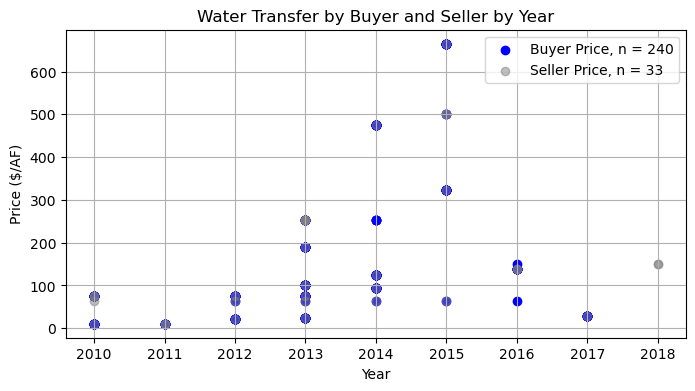

In [22]:
# df_seller['Type'] = 'Seller'
# df_buyer['Type'] = 'Buyer'

# # Step 3: Combine both dataframes
# combined_df = pd.concat([seller_df, buyer_df])

# Step 4: Plot the scatter plot
plt.figure(figsize=(8, 4))

# Scatter plot for seller prices
plt.scatter(df_buyer['Year'],
            df_buyer['Price ($/AF)'],
            color='blue', label='Buyer Price, n = 240')

# Scatter plot for buyer prices
plt.scatter(df_seller['Year'],
            df_seller['Price ($/AF)'],
            color='grey',alpha= 0.5, label='Seller Price, n = 33')

# Step 5: Customize the plot
plt.title('Water Transfer by Buyer and Seller by Year')
plt.xlabel('Year')
plt.ylabel('Price ($/AF)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Align data (CALFEWS output + NQH2O)

In [4]:
import os

# Get the current working directory
current_directory = os.getcwd()

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
current_directory

'C:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\CAL_water_price_index'

In [5]:
%load_ext cython

In [6]:

%%cython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

In [8]:
# # import libraries
# import numpy as np
# import pandas as pd
# import h5py
# import json
# from datetime import datetime
# import matplotlib.pyplot as plt
# from itertools import compress
# import os
# from datetime import datetime
# from calfews_src import *
# from calfews_src.visualizer import Visualizer

# results hdf5 file location from CALFEWS simulations
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

# now load simulation output
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
datDaily


,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,oroville_S,...,kgr_FKC_flow,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout
1996-10-01,3089.041000,12.612089,12.207461,5164.185429,999.990000,9.832066,0.00,5.726281,0.010652,2735.519000,...,0.0,0.0,0.0,0.226822,0.150826,0.000000,0.421546,0.0,0.0,0.0
1996-10-02,3086.058663,12.445528,12.023049,5817.694808,143.444297,9.288595,0.00,4.952727,0.010652,2726.740030,...,0.0,0.0,0.0,0.225233,0.149913,0.000000,0.418451,0.0,0.0,0.0
1996-10-03,3082.631977,11.436628,11.028033,6165.230243,125.700184,8.969256,0.00,4.996364,0.010652,2717.182154,...,0.0,0.0,0.0,0.223644,0.149001,0.000000,0.415355,0.0,0.0,0.0
1996-10-04,3079.841300,13.880646,13.501803,6404.488815,119.075288,10.657190,0.00,6.204298,0.010652,2709.594095,...,0.0,0.0,0.0,0.222055,0.148088,0.000000,0.412259,0.0,0.0,0.0
1996-10-05,3076.415530,14.361502,13.996544,6362.316102,114.818356,6.870744,0.00,4.540165,0.010652,2696.512004,...,0.0,0.0,0.0,0.220466,0.147175,0.000000,0.409164,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,2863.644890,12.784158,12.485682,682.364871,139.062873,5.157025,67.43,2.052893,0.007717,2320.111339,...,0.0,0.0,0.0,0.272287,0.180634,1.329286,0.509123,0.0,0.0,0.0
2024-09-27,2855.791641,10.592134,10.298434,668.985749,139.354394,6.846942,67.43,1.330909,0.009043,2307.931901,...,0.0,0.0,0.0,0.261318,0.173410,1.360784,0.488003,0.0,0.0,0.0
2024-09-28,2851.669590,14.171196,13.869121,659.254008,139.240712,4.407273,67.43,1.275372,0.006623,2305.254175,...,0.0,0.0,0.0,0.250349,0.166186,1.474633,0.466883,0.0,0.0,0.0
2024-09-29,2841.566493,12.941397,12.644390,641.867981,139.404433,2.955372,67.43,2.362314,0.006197,2294.522378,...,0.0,0.0,0.0,0.239380,0.158962,1.771533,0.445762,0.0,0.0,0.0


Rolling avarege of the CALFEWS output (6-M)

In [9]:
# Define the rolling window size (6 months)
# Note: Pandas uses '180D' for a 6-month period assuming approx. 30 days per month
window_size = '180D'

# Compute the past 6-month rolling average 
average_values_df = datDaily.rolling(window=window_size, center=False).mean()

# Reset the index to have 'Date' as a column again if needed
# average_values_df.reset_index(inplace=True)

average_values_df.head()

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,oroville_S,...,kgr_FKC_flow,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout
1996-10-01,3089.041000,12.612089,12.207461,5164.185429,999.990000,9.832066,0.0,5.726281,0.010652,2735.519000,...,0.0,0.0,0.0,0.226822,0.150826,0.0,0.421546,0.0,0.0,0.0
1996-10-02,3087.549831,12.528809,12.115255,5490.940118,571.717148,9.560331,0.0,5.339504,0.010652,2731.129515,...,0.0,0.0,0.0,0.226027,0.150370,0.0,0.419998,0.0,0.0,0.0
1996-10-03,3085.910547,12.164749,11.752848,5715.703493,423.044827,9.363306,0.0,5.225124,0.010652,2726.480395,...,0.0,0.0,0.0,0.225233,0.149913,0.0,0.418451,0.0,0.0,0.0
1996-10-04,3084.393235,12.593723,12.190087,5887.899824,347.052442,9.686777,0.0,5.469917,0.010652,2722.258820,...,0.0,0.0,0.0,0.224438,0.149457,0.0,0.416903,0.0,0.0,0.0
1996-10-05,3082.797694,12.947279,12.551378,5982.783079,300.605625,9.123570,0.0,5.283967,0.010652,2717.109456,...,0.0,0.0,0.0,0.223644,0.149001,0.0,0.415355,0.0,0.0,0.0


In [10]:
merged_df = pd.merge(average_values_df, combined_df, left_on=average_values_df.index, right_on='Date')

# merged_df.set_index("Date", inplace = True)
merged_df

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,oroville_S,...,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout,Date,NQH2O,6_Month_Forward_Avg
0,2756.740000,13.148622,10.504710,2816.678366,197.034228,11.308882,38.113000,5.440859,0.018074,2084.249485,...,0.344922,0.228913,0.627725,0.653214,0.0,0.000000,0.000000,2013-01-09,222.02,244.881538
1,2745.301304,12.433379,10.136773,2935.414049,193.640674,11.609355,36.226778,6.260441,0.018484,2068.109584,...,0.314595,0.208875,0.513999,0.594642,0.0,0.000000,0.000000,2013-01-16,146.89,246.209231
2,2740.277919,11.738987,9.774128,3057.218731,190.065529,11.762810,34.344556,6.940826,0.018706,2059.264558,...,0.287038,0.190669,0.413995,0.541402,0.0,0.000000,0.000000,2013-01-23,113.34,250.956154
3,2741.787106,11.047724,9.417531,3176.814116,172.685408,12.056242,32.465667,7.752298,0.019170,2057.181405,...,0.262308,0.174330,0.326540,0.493597,0.0,0.000000,0.000000,2013-01-30,109.68,257.455769
4,2750.339676,10.417394,9.068192,3295.466359,169.227209,12.390281,30.592778,8.454336,0.019592,2062.325684,...,0.240456,0.159867,0.252404,0.451384,0.0,0.000000,0.000000,2013-02-06,109.77,264.173462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,3873.850984,13.200316,10.070494,3223.214428,45.257192,23.466832,58.305111,8.823702,0.035872,3075.778049,...,0.832784,0.499240,2.602752,1.371977,0.0,0.148483,0.147819,2024-07-17,408.06,427.666000
602,3934.452296,13.959896,10.494029,3182.504741,36.079346,21.562656,60.134556,7.013565,0.032789,3114.173852,...,0.860017,0.517154,2.782551,1.421422,0.0,0.148483,0.147819,2024-07-24,417.58,432.567500
603,3980.475147,14.635651,10.898333,3127.539982,37.390776,20.389983,61.901889,5.856419,0.030997,3143.118704,...,0.883707,0.532659,2.947798,1.464941,0.0,0.148483,0.147819,2024-07-31,429.86,437.563333
604,4011.379597,15.262028,11.251074,3057.293847,40.943119,18.969994,63.429778,4.660121,0.028403,3164.402230,...,0.906107,0.547487,3.095932,1.506572,0.0,0.148483,0.147819,2024-08-07,440.10,441.415000


# Feature selection using Lasso

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import classification_report 
from sklearn.datasets import load_breast_cancer 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
import seaborn as sns 

In [12]:
# Segregating the Feature and Target
X = merged_df.drop("NQH2O", axis=1).values
y = merged_df["NQH2O"].values
time = merged_df.index.values  
# Train Test Split
X_train, X_test, y_train, y_test,time_train, _ = train_test_split(X, y,time, test_size=0.20, random_state=0)
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))
print("Shape of time: {}".format(time_train.shape))

Shape of Train Features: (448, 962)
Shape of Test Features: (112, 962)
Shape of Train Target: (448,)
Shape of Test Target: (112,)
Shape of time: (448,)


In [28]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Lasso on the scaled data
lasso1 = Lasso(alpha=0.1, max_iter=1000000)
lasso1.fit(X_train_scaled, y_train)


Lasso(alpha=0.1, max_iter=1000000)

select important features (954 --> 83)

In [30]:
names=merged_df.drop("NQH2O", axis=1).columns
# print("Column Names: {}".format(names.values))
# Subsetting the features which has more than 0.001 importance.
lasso1_coef = np.abs(lasso1.coef_)
feature_subset=np.array(names)[lasso1_coef>1]
# print("Selected Feature Columns: {}".format(feature_subset))
# Adding the target to the list of feaatures.
feature_subset=np.append(feature_subset, "NQH2O")
# print("Selected Columns: {}".format(feature_subset))
df_new = merged_df[feature_subset]
df_new

,belridge_pumping,belridge_irr_demand,belridge_tableA_carryover,belridge_tableA_paper,buenavista_tableA_projected,buenavista_PIO_recharged,buenavista_tableA_delivery,buenavista_tableA_recharged,buenavista_pumping,buenavista_tableA_turnback,...,centralcoast_tableA_carryover,centralcoast_tableA_carryover,centralcoast_tableA_flood_irrigation,centralcoast_tableA_flood_irrigation,southbay_cvpdelta_delivery,southbay_cvpdelta_delivery,southbay_irr_demand,southbay_irr_demand,6_Month_Forward_Avg,NQH2O
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,0.000000e+00,0.040564,3.411537,0.0,25.708685,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.284668,-0.284668,0.000000,0.000000,11.955148,11.955148,1.403515,1.403515,244.881538,222.02
2013-01-16,0.000000e+00,0.043856,3.411537,0.0,25.995340,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.284668,-0.284668,0.000000,0.000000,13.007719,13.007719,1.305468,1.305468,246.209231,146.89
2013-01-23,0.000000e+00,0.047148,3.411537,0.0,25.995148,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.284668,-0.284668,0.000000,0.000000,14.000912,14.000912,1.234823,1.234823,250.956154,113.34
2013-01-30,5.044004e-02,0.050440,3.411537,0.0,24.951323,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.284668,-0.284668,0.000000,0.000000,15.020764,15.020764,1.299798,1.299798,257.455769,109.68
2013-02-06,5.088993e-02,0.050890,3.411537,0.0,24.566975,0.000000,0.000000,0.000000,0.0,0.000000,...,-0.284668,-0.284668,0.000000,0.000000,15.854685,15.854685,0.996709,0.996709,264.173462,109.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,3.828069e-11,0.045414,3.824479,0.0,30.272259,26.903105,6.244914,6.244914,0.0,-0.607853,...,-9.132192,-9.132192,38.394629,38.394629,24.472947,24.472947,2.091570,2.091570,196.899630,171.14
2023-09-06,1.993994e-04,0.043984,3.824479,0.0,32.822750,27.421154,6.603709,6.603709,0.0,-0.607853,...,-9.132192,-9.132192,41.048154,41.048154,25.164658,25.164658,0.145646,0.145646,198.355185,181.45
2023-09-13,1.289331e-03,0.042605,3.824479,0.0,35.511791,27.678031,6.603709,6.603709,0.0,-0.607853,...,-9.132192,-9.132192,42.301787,42.301787,25.303559,25.303559,0.128454,0.128454,199.644815,188.25


In [31]:
# Get the indices of the selected columns
column_names = merged_df.columns
# Remove duplicates, keep only the first occurrence
unique_column_names = pd.Index(pd.Series(column_names).drop_duplicates().tolist())
selected_indices = [unique_column_names.get_loc(col) for col in feature_subset]

In [32]:
# selected_features = lasso.coef_ != 0
X_train_selected = X_train_scaled[:, selected_indices]  # Select the features from X_train
X_test_selected = X_test_scaled[:, selected_indices]    # Select the features from X_test

# Step 3: Train model using only the selected features
# lasso_selected = Lasso(alpha=0.001, max_iter=10000)

# Set up K-Fold cross-validation (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# lasso_selected.fit(X_train_selected, y_train)
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 2), cv=5, max_iter=100000)
# lasso_cv = LassoCV(alphas=[1,0.1,0.01,10], cv=5, max_iter=100000)

lasso_cv.fit(X_train_selected, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

# Step 4: Make predictions and calculate R² score
y_pred_train = lasso_cv .predict(X_train_selected)
y_pred_test = lasso_cv .predict(X_test_selected)

# R² score & MSE for training data
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# R² score & MSE for test data
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"R² Score (Train): {r2_train}")
print(f"MSE (Train): {mse_train}")
print(f"R² Score (Test): {r2_test}")
print(f"MSE (Test): {mse_test}")


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2721.525209035477, tolerance: 2387.4699047927656
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3161.0153862404404, tolerance: 2387.4699047927656
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2626.34286496017, tolerance: 2387.4699047927656
  positive,
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning:

Optimal alpha: 0.023299518105153717
R² Score (Train): 0.992868620766775
MSE (Train): 469.82905758954183
R² Score (Test): 0.97790947154666
MSE (Test): 1985.9364131601494


In [33]:

# 2. Ridge Regression
ridge = Ridge(max_iter=100000)
params = {"alpha": np.logspace(-4, 0, 50)}
ridge_cv = GridSearchCV(ridge, param_grid={"alpha": params["alpha"]}, cv=kf)
ridge_cv.fit(X_train_selected, y_train)

# Optimal alpha for Ridge
print("Best Ridge Alpha: {}".format(ridge_cv.best_params_))

# Ridge Predictions and R² score
y_pred_train_ridge = ridge_cv.predict(X_train_selected)
y_pred_test_ridge = ridge_cv.predict(X_test_selected)

r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print(f"Ridge R² Score (Train): {r2_train_ridge}")
print(f"Ridge R² Score (Test): {r2_test_ridge}")

# Compare Lasso and Ridge Results
print(f"\nComparison of Lasso vs Ridge:")
print(f"Lasso Train R²: {r2_train}, Ridge Train R²: {r2_train_ridge}")
print(f"Lasso Test R²: {r2_test}, Ridge Test R²: {r2_test_ridge}")

Best Ridge Alpha: {'alpha': 0.3906939937054613}
Ridge R² Score (Train): 0.9924988586096148
Ridge R² Score (Test): 0.9787219761151372

Comparison of Lasso vs Ridge:
Lasso Train R²: 0.992868620766775, Ridge Train R²: 0.9924988586096148
Lasso Test R²: 0.97790947154666, Ridge Test R²: 0.9787219761151372


In [34]:
# Step 2: Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_lasso_sorted = y_pred_train[sorted_indices]  # Ensure predictions are sorted too
y_pred_train_ridge_sorted = y_pred_train_ridge[sorted_indices]

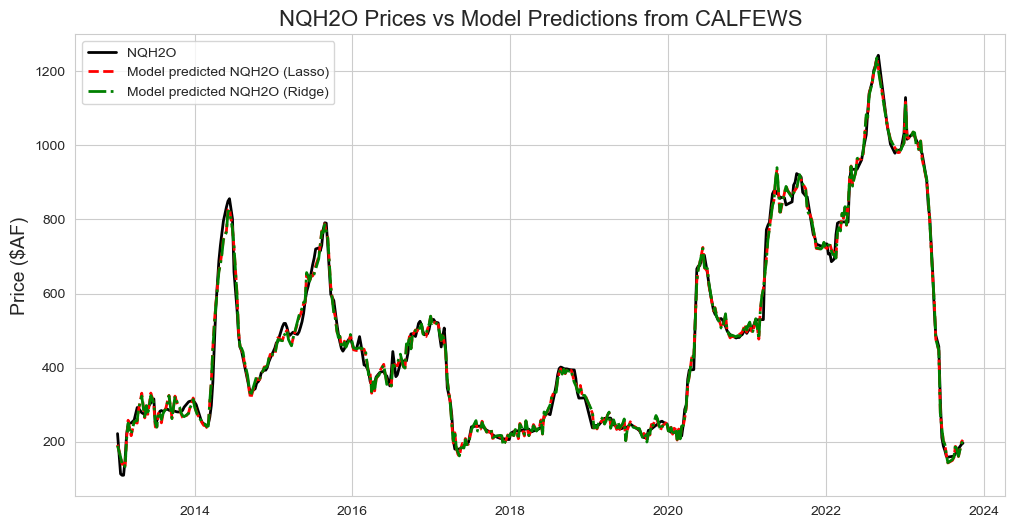

In [35]:
plt.figure(figsize=(12, 6))
# Create a time axis (e.g., 100 time points)
time = np.arange(len(y_train))
# Plot the original and fitted values
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)  # Original values
plt.plot(time_train_sorted, y_pred_train_lasso_sorted, label='Model predicted NQH2O (Lasso)', color='red', linestyle='--', linewidth=2)  # Fitted values
plt.plot(time_train_sorted, y_pred_train_ridge_sorted, label='Model predicted NQH2O (Ridge)', color='green', linestyle='-.', linewidth=2)  # Fitted values

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS', fontsize=16)
# plt.xlabel('Time', fontsize=14)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [48]:
# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check how many components are selected
print(f"Number of components selected: {X_train_pca.shape[1]}")

# Step 3: Train models on PCA-transformed data

# Lasso Model
lasso = LassoCV(alphas=[0.1, 1, 10, 0.01], cv =3)
lasso.fit(X_train_pca, y_train)

y_pred_train_lasso_pca = lasso.predict(X_train_pca)
y_pred_test_lasso_pca = lasso.predict(X_test_pca)

r2_train_lasso = r2_score(y_train, y_pred_train_lasso_pca)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso_pca)

print(f"Lasso R² (Train): {r2_train_lasso}")
print(f"Lasso R² (Test): {r2_test_lasso}")

# Ridge Model
ridge = RidgeCV(alphas=[0.1, 1, 10, 0.01], cv =3)
ridge.fit(X_train_pca, y_train)

y_pred_train_ridge_pca = ridge.predict(X_train_pca)
y_pred_test_ridge_pca = ridge.predict(X_test_pca)

r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print(f"Ridge R² (Train): {r2_train_ridge}")
print(f"Ridge R² (Test): {r2_test_ridge}")

Number of components selected: 28
Lasso R² (Train): 0.9035939943542505
Lasso R² (Test): 0.9035262180509789
Ridge R² (Train): 0.9925565106669413
Ridge R² (Test): 0.977151369449076


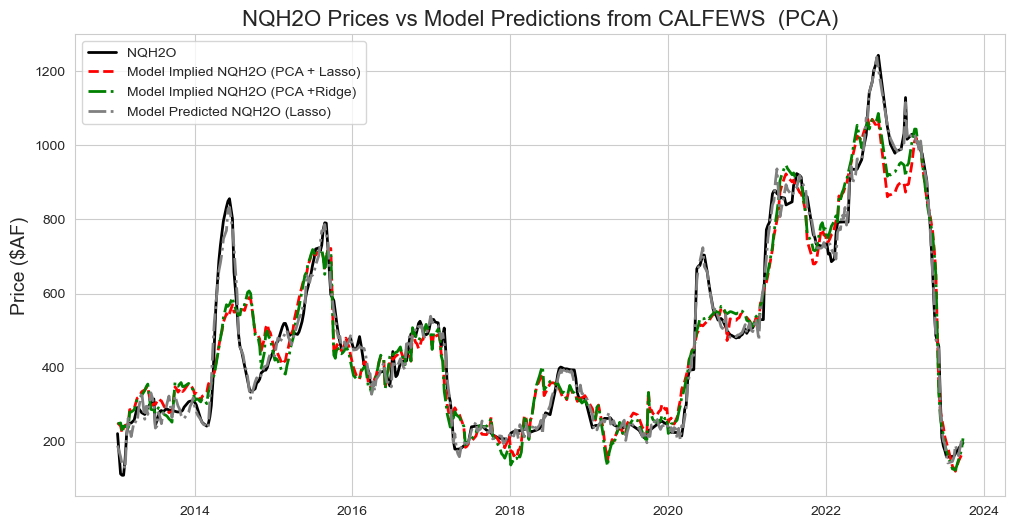

In [49]:
# Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_lasso_pca_sorted = y_pred_train_lasso_pca[sorted_indices]  # Ensure predictions are sorted too
y_pred_train_ridge_pca_sorted = y_pred_train_ridge_pca[sorted_indices]

#  Plot the sorted data
plt.figure(figsize=(12, 6))

# Plot original values (sorted)
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_lasso_pca_sorted, label='Model Implied NQH2O (PCA + Lasso)', color='red', linestyle='--', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_ridge_pca_sorted, label='Model Implied NQH2O (PCA +Ridge)', color='green', linestyle='-.', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_lasso_sorted, label='Model Predicted NQH2O (Lasso)', color='grey', linestyle='-.', linewidth=2)

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS  (PCA)', fontsize=16)
# plt.xlabel('Time', fontsize=14)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Format the x-axis for dates (if needed)
# plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

using PCA for dim reduction in regression ignores the relationship between X and y. So dropping low variance components while ignoring their relationship to y is a dubious idea.
* It is not uncommon to see that the major PCs are insignificant in a prediction model. The PC is the largest force or variation source in by definition, but not necessarily the one that correlates with any outcome variable with the strongest correlation.
* Both penalize low variance directions in X. 
* avoid under-fitting, we can always do hyper-parameter tuning to find best lambda.
While PCA has been widely used, it is often criticized as a black box model that lacks interpretability. It depends on the circumstances where the PCA is used. Sometimes, it is not easy to connect the identified principal components with physical entities. 

https://dataanalyticsbook.info/chapter-8-scalability-lasso-pca.html#:~:text=Both%20methods%20can%20reduce%20the,a.k.a.%2C%20the%20new%20features).


Alignment of pricing data - Tabular data 
Y - x1, x2,,, Xn 

# Feature selection + RF

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)
train_indices, test_indices = [], []
for train_index, test_index in tscv.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Take the last split for actual evaluation
train_index = train_indices[-1]
test_index = test_indices[-1]

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e+03, tolerance: 1.477e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


R² score: 0.008087084516935295
MSE_test: 109132.08298477418
R² score_train: 0.9952308509960217
MSE_train: 179.3175936695279


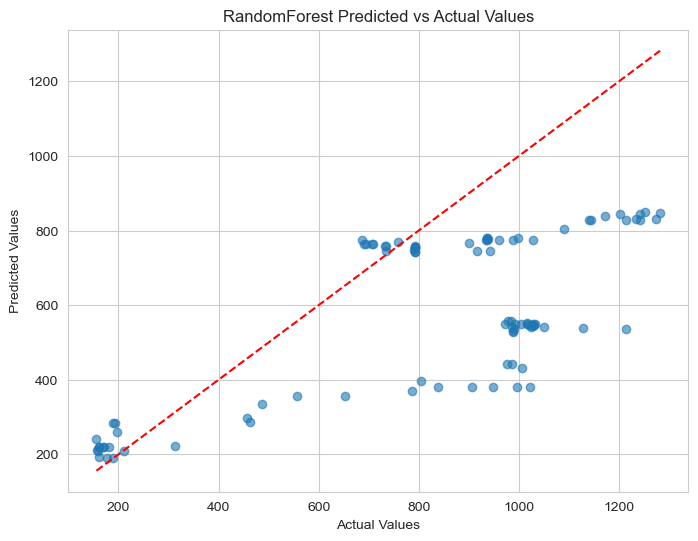

Selected Features and Coefficients:
Feature: buenavista_tableA_projected, Coefficient: -6.439338623067302
Feature: buenavista_tableA_turnback, Coefficient: 0.139744505451375
Feature: buenavista_kern_carryover, Coefficient: -5.724223994194993
Feature: buenavista_exchanged_GW, Coefficient: 17.206177967679466
Feature: cawelo_tableA_projected, Coefficient: -3.1584299697961433
Feature: cawelo_tableA_carryover, Coefficient: -9.74869451962797
Feature: henrymiller_exchanged_GW, Coefficient: 6.741238551728443
Feature: ID4_irr_demand, Coefficient: -17.721022711714784
Feature: tehachapi_recover_banked, Coefficient: 4.033390546044626
Feature: tejon_pumping, Coefficient: 4.109965513697653
Feature: northkern_kings_flood_irrigation, Coefficient: -4.444760019067031
Feature: arvin_pumping, Coefficient: 22.650646196991318
Feature: arvin_inleiu_irrigation, Coefficient: -1.9884347931121291
Feature: delano_friant2_projected, Coefficient: -6.3389748782598865
Feature: exeter_friant1_carryover, Coefficient: 1

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
X = merged_df.drop(["6_Month_Forward_Avg", "NQH2O"], axis=1).values
y = merged_df["NQH2O"].values
time = merged_df.index.values  

X_train, X_test, y_train, y_test, time_train,  _ = train_test_split(X, y, time, test_size=0.20, random_state=0)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit LassoCV model with more iterations and adjusted tolerance
lasso_cv = LassoCV(cv=5, max_iter=5000, tol=1e-4)
lasso_cv.fit(X_train_scaled, y_train)

# Feature selection
sfm = SelectFromModel(lasso_cv, prefit=True)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# Train a Random Forest Regressor using the selected features
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = model.predict(X_test_selected)
y_pred_train = model.predict(X_train_selected)


# Calculate R² and MSE
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"R² score: {r2_test}")
print(f"MSE_test: {mse_test}")
print(f"R² score_train: {r2_train}")
print(f"MSE_train: {mse_train}")

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.show()

# Analyze selected features and their importance
selected_feature_indices = np.where(sfm.get_support())[0]
selected_features = merged_df.columns[selected_feature_indices]
coefficients = lasso_cv.coef_

# Print selected features and their coefficients
print("Selected Features and Coefficients:")
selected_features_with_coefficients = zip(selected_features, coefficients[selected_feature_indices])
for feature, coef in selected_features_with_coefficients:
    print(f"Feature: {feature}, Coefficient: {coef}")


In [52]:
X_train_selected.shape

(156, 67)

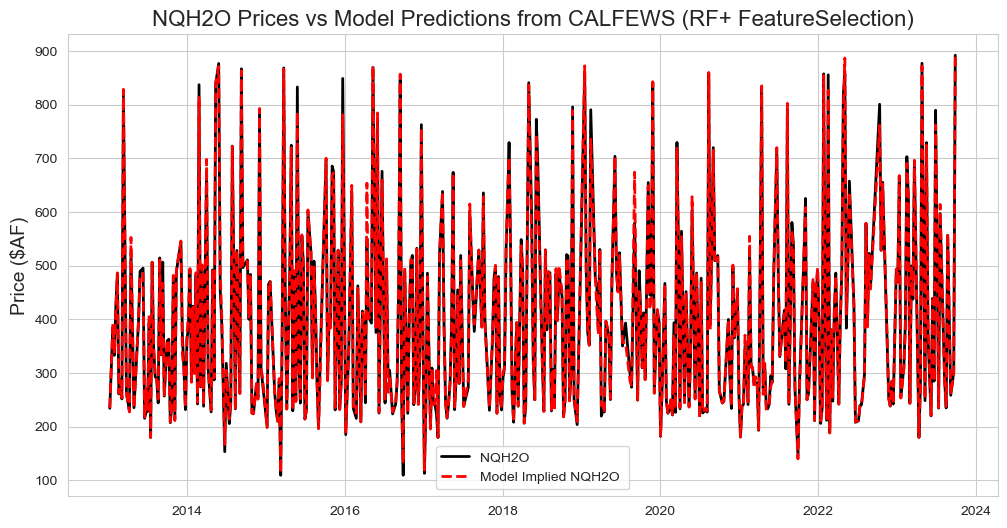

In [126]:
# Step 2: Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_sorted = y_pred_train[sorted_indices]  # Ensure predictions are sorted too

#  Plot the sorted data
plt.figure(figsize=(12, 6))

# Plot original values (sorted)
plt.plot(time_train_sorted, y_train_sorted, label='NQH2O', color='black', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_sorted, label='Model Implied NQH2O ', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('NQH2O Prices vs Model Predictions from CALFEWS (RF+ FeatureSelection)', fontsize=16)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

# synthetic data file cut

In [24]:
import json

date_dict = {str(i): "9/30/2026" for i in range(1, 101)}
print(json.dumps(date_dict, indent=4))

# year_dict = {str(i): 2026 for i in range(1, 101)}
# print(json.dumps(year_dict, indent=4))

{
    "1": "9/30/2026",
    "2": "9/30/2026",
    "3": "9/30/2026",
    "4": "9/30/2026",
    "5": "9/30/2026",
    "6": "9/30/2026",
    "7": "9/30/2026",
    "8": "9/30/2026",
    "9": "9/30/2026",
    "10": "9/30/2026",
    "11": "9/30/2026",
    "12": "9/30/2026",
    "13": "9/30/2026",
    "14": "9/30/2026",
    "15": "9/30/2026",
    "16": "9/30/2026",
    "17": "9/30/2026",
    "18": "9/30/2026",
    "19": "9/30/2026",
    "20": "9/30/2026",
    "21": "9/30/2026",
    "22": "9/30/2026",
    "23": "9/30/2026",
    "24": "9/30/2026",
    "25": "9/30/2026",
    "26": "9/30/2026",
    "27": "9/30/2026",
    "28": "9/30/2026",
    "29": "9/30/2026",
    "30": "9/30/2026",
    "31": "9/30/2026",
    "32": "9/30/2026",
    "33": "9/30/2026",
    "34": "9/30/2026",
    "35": "9/30/2026",
    "36": "9/30/2026",
    "37": "9/30/2026",
    "38": "9/30/2026",
    "39": "9/30/2026",
    "40": "9/30/2026",
    "41": "9/30/2026",
    "42": "9/30/2026",
    "43": "9/30/2026",
    "44": "9/30/20

In [20]:
import pandas as pd
from datetime import datetime
import os

start_date = datetime(1906, 10, 1)
end_date = datetime(1908, 9, 29) # to account for the leap year in 2024
folder = 'C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS/calfews_src/data/MGHMM_synthetic/'

for i in range(100):
    input_filename = os.path.join(folder, f'DailyQ_s{i}.csv')
    output_filename = os.path.join(folder, f'DailyQ_s{i}.csv')
    df = pd.read_csv(input_filename)
   
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df = filtered_df.drop(columns=['Date'])
    
    filtered_df.to_csv(output_filename, index=False)
    
    # print(f'Processed {input_filename} -> {output_filename}')

# CALFEWS output --> 6-M Forward Avg


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Linear Model - R² for Train: 0.8832879908512576
Linear Model - R² for Test: 0.8788903496408785
Quadratic Model - R² for Train: 0.9996998340267522
Quadratic Model - R² for Test: 0.9994048143778214
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min

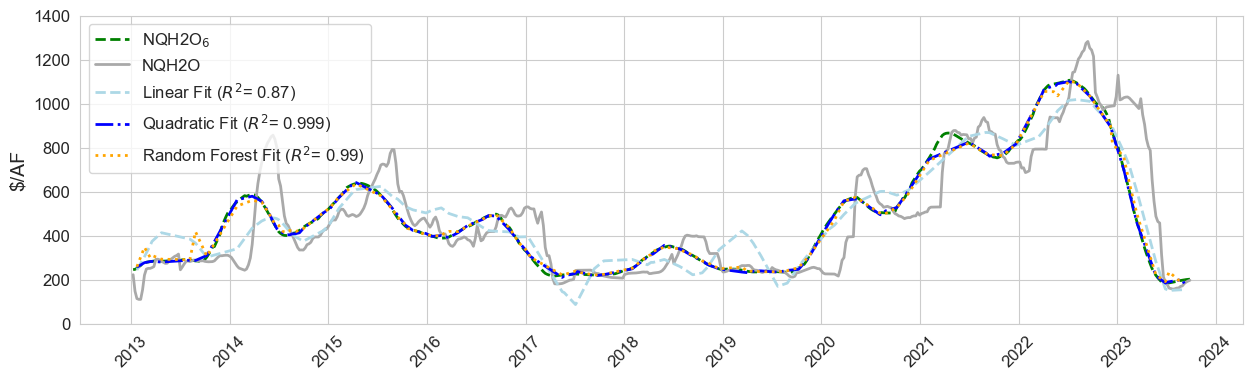

In [ ]:
%%time
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


# Assuming 'merged_df' is already loaded
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# Create a water year column based on the Date column
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)

X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
# Drop non-numeric columns (Only keep numeric columns for PCA)
X = X.drop(columns=non_numeric_columns)

# 2. Train-test split 
X_train, X_test, y_train, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']

# 3.Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4.PCA for dimensionality reduction & feature selection
pca = PCA(n_components=0.95)  # keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 6. Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_pca, y_train)

# Evaluate the linear model
y_pred_linear_train = linear_model.predict(X_train_pca)
y_pred_linear_test = linear_model.predict(X_test_pca)

r2_linear_train = r2_score(y_train, y_pred_linear_train)
r2_linear_test = r2_score(y_test, y_pred_linear_test)

print(f'Linear Model - R² for Train: {r2_linear_train}')
print(f'Linear Model - R² for Test: {r2_linear_test}')

# 7. Train a quadratic (polynomial) model
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_pca)
X_test_poly = poly_features.transform(X_test_pca)
quadratic_model = LinearRegression()
quadratic_model.fit(X_train_poly, y_train)

# Evaluate the quadratic model
y_pred_quadratic_train = quadratic_model.predict(X_train_poly)
y_pred_quadratic_test = quadratic_model.predict(X_test_poly)

r2_quadratic_train = r2_score(y_train, y_pred_quadratic_train)
r2_quadratic_test = r2_score(y_test, y_pred_quadratic_test)

print(f'Quadratic Model - R² for Train: {r2_quadratic_train}')
print(f'Quadratic Model - R² for Test: {r2_quadratic_test}')

# 8. Hyperparameter tuning for Random Forest model using GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3,  verbose=2)
grid_search.fit(X_train_pca, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Evaluate the Random Forest model
y_pred_rf_train = best_rf.predict(X_train_pca)
y_pred_rf_test = best_rf.predict(X_test_pca)

r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print(f'Random Forest Model - Best Params: {grid_search.best_params_}')
print(f'Random Forest Model - R² for Train: {r2_rf_train}')
print(f'Random Forest Model - R² for Test: {r2_rf_test}')


# 9. Create a DataFrame for the test set predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_quadratic_test,
    'predicted_rf': y_pred_rf_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 10. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label='Linear Fit ($R^{2}$= 0.87)', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label='Quadratic Fit ($R^{2}$= 0.999)', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label='Random Forest Fit ($R^{2}$= 0.99)', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.show()


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  app.launch_new_instance()
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Linear Model - Cross-Validation MSE (mean ± std): 7476.8392 ± 1498.4338
Linear Model - Cross-Validation R² (mean ± std): 0.8704 ± 0.0318
Linear Model - R² for Train: 0.8832879908512576
Linear Model - R² for Test: 0.8788903496408785
Quadratic Model - R² for Train: 1.0
Quadratic Model - R² for Test: 0.9993359040647127
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.4s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.5s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200

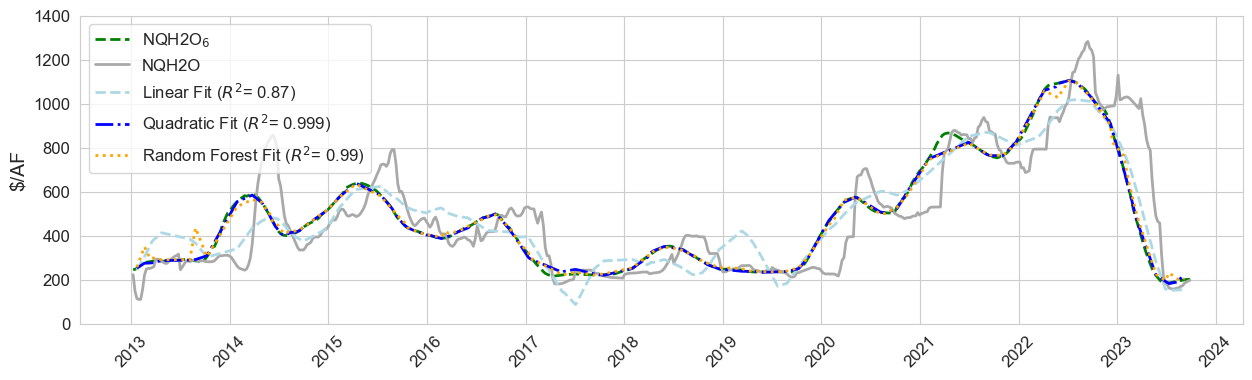

Wall time: 13min 32s


In [25]:
%%time
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Assuming 'merged_df' is already loaded
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# Create a water year column based on the Date column
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)

X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
# Drop non-numeric columns (Only keep numeric columns for PCA)
X = X.drop(columns=non_numeric_columns)

# 2. Train-test split 
X_train, X_test, y_train, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']

# 3. Feature scaling and PCA within a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

# 4. K-Fold Cross-Validation for Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=kf)

mse_mean = -np.mean(mse_scores)
mse_std = np.std(mse_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)

print(f'Linear Model - Cross-Validation MSE (mean ± std): {mse_mean:.4f} ± {mse_std:.4f}')
print(f'Linear Model - Cross-Validation R² (mean ± std): {r2_mean:.4f} ± {r2_std:.4f}')

# 5. Train a linear regression model on the full training set using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the linear model on the test set
y_pred_linear_train = pipeline.predict(X_train)
y_pred_linear_test = pipeline.predict(X_test)

r2_linear_train = r2_score(y_train, y_pred_linear_train)
r2_linear_test = r2_score(y_test, y_pred_linear_test)

print(f'Linear Model - R² for Train: {r2_linear_train}')
print(f'Linear Model - R² for Test: {r2_linear_test}')

# 6. Train a quadratic (polynomial) model
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
quadratic_model = LinearRegression()
quadratic_model.fit(X_train_poly, y_train)

# Evaluate the quadratic model
y_pred_quadratic_train = quadratic_model.predict(X_train_poly)
y_pred_quadratic_test = quadratic_model.predict(X_test_poly)

r2_quadratic_train = r2_score(y_train, y_pred_quadratic_train)
r2_quadratic_test = r2_score(y_test, y_pred_quadratic_test)

print(f'Quadratic Model - R² for Train: {r2_quadratic_train}')
print(f'Quadratic Model - R² for Test: {r2_quadratic_test}')

# 7. Hyperparameter tuning for Random Forest model using GridSearchCV
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Evaluate the Random Forest model
y_pred_rf_train = best_rf.predict(X_train)
y_pred_rf_test = best_rf.predict(X_test)

r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print(f'Random Forest Model - Best Params: {grid_search.best_params_}')
print(f'Random Forest Model - R² for Train: {r2_rf_train}')
print(f'Random Forest Model - R² for Test: {r2_rf_test}')

# 8. Create a DataFrame for the test set predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_quadratic_test,
    'predicted_rf': y_pred_rf_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 9. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label='Linear Fit ($R^{2}$= 0.87)', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label='Quadratic Fit ($R^{2}$= 0.999)', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label='Random Forest Fit ($R^{2}$= 0.99)', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.show()

https://medium.com/@masadeghi6/how-to-split-your-data-for-machine-learning-eae893a8799c

data preprocessing and feature selction

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, r2_score

# Assuming 'merged_df' is already loaded
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# Create a water year column based on the Date column
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)

X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
# Drop non-numeric columns (Only keep numeric columns for PCA)
X = X.drop(columns=non_numeric_columns)

# Split the dataset into train-validation and test sets
X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']

# Standardize the datasets
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # keep 95% of variance
X_train_val_selected = pca.fit_transform(X_train_val, y_train_val)
X_test_selected = pca.transform(X_test)


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  app.launch_new_instance()
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
min_features_to_select = 1  # Minimum number of features to consider
lr = LinearRegression()
# lr = RandomForestRegressor()
cv = KFold(n_splits=3)

rfecv = RFECV(
    estimator=lr,
    step=1,
    cv=cv,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    # n_jobs=2,
)
X_train_val_selected = rfecv.fit(X_train_val, y_train_val)
# X_test_selected = rfe_selector.transform(X_test)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Feature ranking: {rfecv.ranking_}")

Optimal number of features: 100
Feature ranking: [ 484  424 1134 ... 1192  193  997]


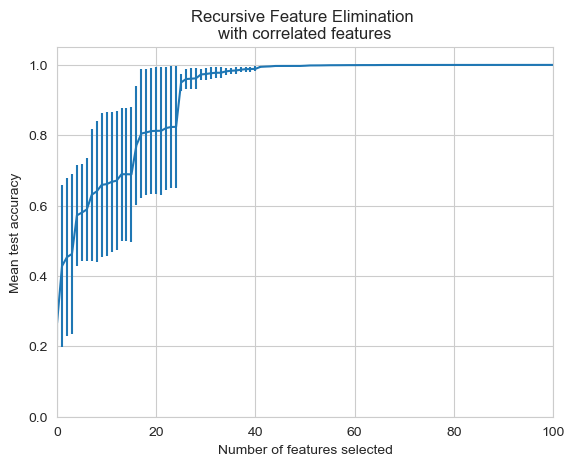

In [15]:
n_features = 2148
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.xlim(0, 100)
plt.ylim(0, 1.05)
plt.show()

In [38]:
selected_features_mask = rfecv.support_

# Get the ranking of features (1 indicates selected features)
feature_ranking = rfecv.ranking_

# Print feature rankings
print(f"Feature ranking: {feature_ranking}")

# Select features based on the mask
X_train_val_selected = X_train_val[:, selected_features_mask]
X_test_selected = X_test[:, selected_features_mask]

# Print the shape to show the number of selected features
print(f"Shape of X_train_val with selected features: {X_train_val_selected.shape}")
print(f"Shape of X_test with selected features: {X_test_selected.shape}")

Feature ranking: [ 484  424 1134 ... 1192  193  997]
Shape of X_train_val with selected features: (448, 100)
Shape of X_test with selected features: (112, 100)


Linear Regression Train R^2: 0.8039404913583056
Linear Regression Test R^2: 0.7993510315846479
Polynomial Regression Train R^2: 0.9990836839830204
Polynomial Regression Test R^2: 0.9974916851951081
Random Forest Train R^2: 0.998435507083281
Random Forest Test R^2: 0.9757304112367251


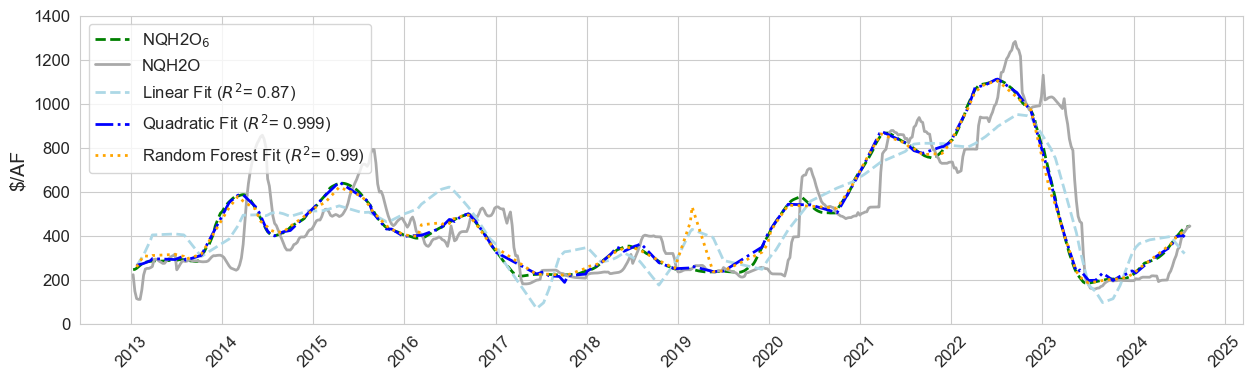

In [13]:

# Define a scorer for R-Squared
scorer = make_scorer(r2_score)

# Linear Regression
linear_reg = LinearRegression()
# linear_reg_grid = {}
# linear_reg_cv = GridSearchCV(estimator=linear_reg, param_grid=linear_reg_grid, scoring=scorer, cv=1) #no need for hyperparameter tuning for linear fit
# linear_reg_cv.fit(X_train_val_selected, y_train_val)
# y_pred_linear_train = linear_reg_cv.predict(X_train_val_selected)
# y_pred_linear_test = linear_reg_cv.predict(X_test_selected)
y_pred_linear_train = cross_val_predict(linear_reg, X_train_val_selected, y_train_val, cv=3)
linear_reg.fit(X_train_val_selected, y_train_val)
y_pred_linear_test = linear_reg.predict(X_test_selected)

# Polynomial Regression
polynomial_reg_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])
polynomial_reg_grid = {'poly__degree': [2, 3, 4]}
polynomial_reg_cv = GridSearchCV(estimator=polynomial_reg_pipeline, param_grid=polynomial_reg_grid, scoring=scorer, cv=3)
polynomial_reg_cv.fit(X_train_val_selected, y_train_val)
y_pred_poly_train = polynomial_reg_cv.predict(X_train_val_selected)
y_pred_poly_test = polynomial_reg_cv.predict(X_test_selected)

# Random Forest
random_forest = RandomForestRegressor(random_state=42)
random_forest_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
random_forest_cv = GridSearchCV(estimator=random_forest, param_grid=random_forest_grid, scoring=scorer, cv=3)
random_forest_cv.fit(X_train_val_selected, y_train_val)
y_pred_rf_train = random_forest_cv.predict(X_train_val_selected)
y_pred_rf_test = random_forest_cv.predict(X_test_selected)

# Best model from Linear Regression
# best_linear_reg = linear_reg_cv.best_estimator_
best_polynomial_reg = polynomial_reg_cv.best_estimator_
best_random_forest = random_forest_cv.best_estimator_

# Compute R^2 on the train set
linear_reg_train_r2 = r2_score(y_train_val, y_pred_linear_train)
polynomial_reg_train_r2 = r2_score(y_train_val, best_polynomial_reg.predict(X_train_val_selected))
random_forest_train_r2 = r2_score(y_train_val, best_random_forest.predict(X_train_val_selected))

# Compute R^2 on the test set
linear_reg_test_r2 = r2_score(y_test, y_pred_linear_test)
polynomial_reg_test_r2 = r2_score(y_test, best_polynomial_reg.predict(X_test_selected))
random_forest_test_r2 = r2_score(y_test, best_random_forest.predict(X_test_selected))

# Print the performance
print(f"Linear Regression Train R^2: {linear_reg_train_r2}")
print(f"Linear Regression Test R^2: {linear_reg_test_r2}")

print(f"Polynomial Regression Train R^2: {polynomial_reg_train_r2}")
print(f"Polynomial Regression Test R^2: {polynomial_reg_test_r2}")

print(f"Random Forest Train R^2: {random_forest_train_r2}")
print(f"Random Forest Test R^2: {random_forest_test_r2}")

# predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_poly_test,
    'predicted_rf': y_pred_rf_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 9. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label='Linear Fit ($R^{2}$= 0.87)', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label='Quadratic Fit ($R^{2}$= 0.999)', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label='Random Forest Fit ($R^{2}$= 0.99)', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.show()

# CALFEWS Input files direclty for prediction

In [163]:
# Get the current working directory
current_directory = os.getcwd()

os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
current_directory
input = pd.read_csv('calfews_src/data/input/cord-sim_realtime.csv')

input['datetime'] = pd.to_datetime(input['datetime'])
input.set_index("datetime", inplace = True)
input.head()

,SHA_snow,SHA_fnf,SHA_storage,SHA_inf,SHA_otf,SHA_evap,SHA_precip,SHA_gains,SHA_fci,ORO_snow,...,SJ_gains,EAST_gains,delta_depletions,CCC_pump,BRK_pump,delta_inflow,vernalis_inflow,SOB_pump,LAP_pump,EDM_pump
datetime,,,,,,,,,,,,,,,,,,,,,
1995-10-01,0.2,9906.419355,3129000,0.0,0,137,0.0,9479,0.00000,0.0,...,0,0,0.0,0.0,0,0,0,268.0,196.0,304.0
1995-10-02,0.2,9906.419355,3128030,5240.0,5506,206,0.0,3426,10393.32516,0.0,...,0,0,0.0,0.0,0,0,0,390.0,226.0,411.0
1995-10-03,0.2,9906.419355,3125931,3800.0,4653,103,0.0,3805,17410.80310,0.0,...,0,0,0.0,0.0,0,0,0,356.0,255.0,660.0
1995-10-04,0.2,9906.419355,3123830,3455.0,4275,240,0.0,3457,23393.11379,0.0,...,0,0,0.0,0.0,0,0,0,277.0,244.0,715.0
1995-10-05,0.2,9906.419355,3124763,4245.0,3542,233,0.0,3844,30643.24156,0.0,...,0,0,0.0,0.0,0,0,0,278.0,266.0,704.0


In [164]:
window_size = '180D'   # Compute the 6-month rolling average centered on each date
average_values_df = input.rolling(window=window_size, center=False).mean()
merged_df = pd.merge(average_values_df, combined_df, left_on='datetime', right_on='Date')

# merged_df.set_index("Date", inplace = True)

In [141]:
merged_df

,SHA_snow,SHA_fnf,SHA_storage,SHA_inf,SHA_otf,SHA_evap,SHA_precip,SHA_gains,SHA_fci,ORO_snow,...,CCC_pump,BRK_pump,delta_inflow,vernalis_inflow,SOB_pump,LAP_pump,EDM_pump,Date,NQH2O,6_Month_Forward_Avg
0,38.113000,18055.589785,2.843132e+06,5701.561111,6261.872222,133.188889,0.205444,2743.100000,134000.493668,20.688833,...,233.788889,75.972222,24118.511111,1350.077778,383.922222,311.650000,4511.238889,2013-01-09,222.02,244.881538
1,36.226778,18422.249283,2.837547e+06,5853.050000,5926.433333,127.955556,0.205222,3156.305556,147715.832575,20.738500,...,230.011111,72.905556,24255.755556,1394.622222,369.005556,289.605556,4426.238889,2013-01-16,146.89,246.209231
2,34.344556,18788.908782,2.837984e+06,5930.416667,5592.300000,120.766667,0.205222,3499.333333,159711.484956,20.818167,...,224.633333,69.705556,24154.866667,1424.933333,361.100000,267.594444,4363.427778,2013-01-23,113.34,250.956154
3,32.465667,19169.734946,2.844972e+06,6078.355556,5247.055556,113.133333,0.209722,3908.450000,170981.995849,20.913833,...,218.555556,66.483333,24058.694444,1451.800000,349.972222,245.061111,4319.661111,2013-01-30,109.68,257.455769
4,30.592778,19511.023694,2.858987e+06,6246.766667,4928.183333,105.811111,0.209722,4262.394444,182049.285982,21.009500,...,212.977778,63.022222,23963.872222,1492.372222,330.150000,224.844444,4284.922222,2013-02-06,109.77,264.173462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,156.582889,28967.990143,4.017718e+06,9413.472222,7022.111111,203.177778,0.161667,4142.533333,25099.115946,142.776889,...,459.804321,139.716667,83987.461111,37250.638889,252.661111,297.594444,5450.250000,2023-08-30,171.14,196.899630
556,158.091333,26738.887885,4.045517e+06,9218.022222,7219.177778,207.805556,0.149000,3757.616667,17527.648764,144.477333,...,464.990329,148.483333,82415.594444,36506.083333,269.866667,307.516667,5610.538889,2023-09-06,181.45,198.355185
557,159.149111,24512.498034,4.060122e+06,8025.122222,7434.327778,213.338889,0.094000,2816.522222,12240.210845,145.428944,...,460.882305,157.283333,75982.405556,34757.411111,286.961111,316.733333,5655.300000,2023-09-13,188.25,199.644815
558,159.895222,22286.108184,4.056914e+06,7243.500000,7628.650000,218.844444,0.077278,1925.572222,8547.795745,146.049889,...,456.914198,166.994444,67977.622222,32192.077778,303.683333,324.877778,5677.794444,2023-09-20,192.97,200.702222


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  if sys.path[0] == "":


Linear Model - R² for Train: 0.9057498064678623
Linear Model - R² for Test: 0.8923323038679656
Quadratic Model - R² for Train: 0.9933664279624331
Quadratic Model - R² for Test: 0.9919204970453187
Exponential Model - R² for Train: 0.8929121468321306
Exponential Model - R² for Test: 0.8839178954921548


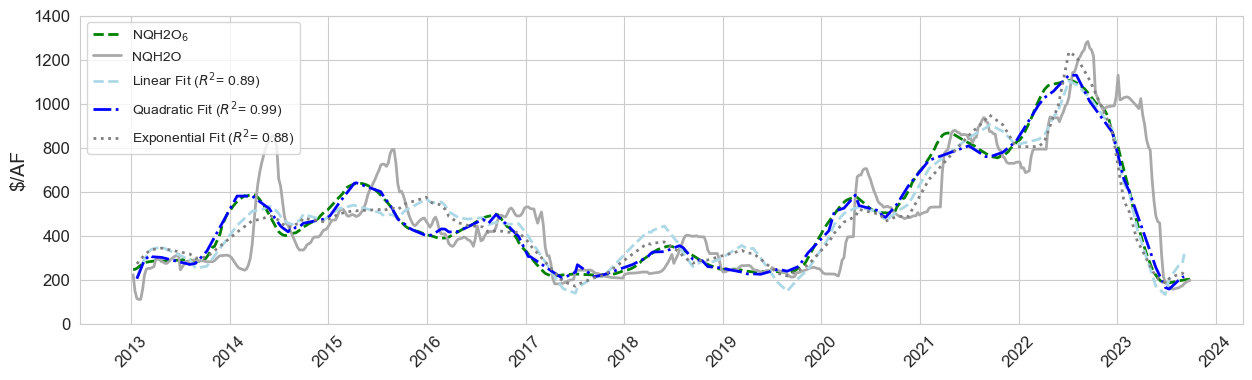

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# # merged_df['year'] = merged_df['datetime'].dt.year
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)
# Display the first few rows to confirm the new 'year' column
# print(merged_df.head())

# 3. Preprocessing
# Assume 'target' is the column we're trying to predict and 'date' is the date column which we will drop
X = merged_df.drop(columns=['6_Month_Forward_Avg', 'NQH2O', 'Date'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
# Drop non-numeric columns (Only keep numeric columns for PCA)
X = X.drop(columns=non_numeric_columns)

# 4. PCA for dimensionality reduction
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)  # keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# 5. Train-test split (retain the date index of the test set)
X_train, X_test, y_train, y_test, train_date, test_date = train_test_split(X_pca, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']

# 6. Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate the linear model
y_pred_linear_train = linear_model.predict(X_train)
y_pred_linear_test = linear_model.predict(X_test)

r2_linear_train = r2_score(y_train, y_pred_linear_train)
r2_linear_test = r2_score(y_test, y_pred_linear_test)

print(f'Linear Model - R² for Train: {r2_linear_train}')
print(f'Linear Model - R² for Test: {r2_linear_test}')

# 7. Train a quadratic (polynomial) model
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

quadratic_model = LinearRegression()
quadratic_model.fit(X_train_poly, y_train)

# Evaluate the quadratic model
y_pred_quadratic_train = quadratic_model.predict(X_train_poly)
y_pred_quadratic_test = quadratic_model.predict(X_test_poly)

r2_quadratic_train = r2_score(y_train, y_pred_quadratic_train)
r2_quadratic_test = r2_score(y_test, y_pred_quadratic_test)

print(f'Quadratic Model - R² for Train: {r2_quadratic_train}')
print(f'Quadratic Model - R² for Test: {r2_quadratic_test}')

# 8. Train an exponential model
linear_model_exp = LinearRegression()
linear_model_exp.fit(X_train, np.log1p(y_train))

# Evaluate the exponential model
y_pred_exp_train_log = linear_model_exp.predict(X_train_pca)
y_pred_exp_test_log = linear_model_exp.predict(X_test)

y_pred_exp_train = np.expm1(y_pred_exp_train_log)
y_pred_exp_test = np.expm1(y_pred_exp_test_log)

r2_exp_train = r2_score(y_train, y_pred_exp_train)
r2_exp_test = r2_score(y_test, y_pred_exp_test)

print(f'Exponential Model - R² for Train: {r2_exp_train}')
print(f'Exponential Model - R² for Test: {r2_exp_test}')

# 9. Create a DataFrame for the test set predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_quadratic_test,
    'predicted_exponential': y_pred_exp_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 10. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label='Linear Fit ($R^{2}$= 0.89)', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label='Quadratic Fit ($R^{2}$= 0.99)', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_exponential'], label='Exponential Fit ($R^{2}$= 0.88)', linestyle=':', color='grey', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10, loc='upper left')

plt.show()

# Time series ML

In [65]:
# Convert 'datetime' column to datetime type
input['datetime'] = pd.to_datetime(input['datetime'])
input.set_index('datetime', inplace=True)

# Initialize an empty DataFrame to store the 12-month averages
yearly_avg_df = pd.DataFrame(index=input.index)
yearly_avg_df = pd.DataFrame(index=input.index, columns=input.columns)
# Iterate through each date in the original DataFrame
for current_date in input.index:
    
    start_date = current_date - pd.DateOffset(months=12)# Define the date range for the past 12 months
    past_year_data = input[start_date:current_date]  # Filter the original DataFrame to get only the data from the past 12 months
    past_year_avg = past_year_data.mean() # Calculate the mean for the past 12 months for each column
    yearly_avg_df.loc[current_date] = past_year_avg    # Assign the calculated averages to the appropriate row in the `yearly_avg_df`

# Reset the index to have 'datetime' as a column again (optional)
yearly_avg_df.reset_index(inplace=True)

# Save the new dataset to a CSV file (optional)
yearly_avg_output_path = 'sim_realtime_yearly_avg.csv'
yearly_avg_df.to_csv(yearly_avg_output_path, index=False)

# Display the first few rows of the new dataset
yearly_avg_df.head()

,datetime,SHA_snow,SHA_fnf,SHA_storage,SHA_inf,SHA_otf,SHA_evap,SHA_precip,SHA_gains,SHA_fci,...,SJ_gains,EAST_gains,delta_depletions,CCC_pump,BRK_pump,delta_inflow,vernalis_inflow,SOB_pump,LAP_pump,EDM_pump
0,1995-10-01,0.2,9906.419355,3129000.0,0.0,0.0,137.0,0.0,9479.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268.0,196.0,304.0
1,1995-10-02,0.2,9906.419355,3128515.0,2620.0,2753.0,171.5,0.0,6452.5,5196.66258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.0,211.0,357.5
2,1995-10-03,0.2,9906.419355,3127653.666667,3013.333333,3386.333333,148.666667,0.0,5570.0,9268.042753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,338.0,225.666667,458.333333
3,1995-10-04,0.2,9906.419355,3126697.75,3123.75,3608.5,171.5,0.0,5041.75,12799.310513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,322.75,230.25,522.5
4,1995-10-05,0.2,9906.419355,3126310.8,3348.0,3595.2,183.8,0.0,4802.2,16368.096722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,313.8,237.4,558.8


In [67]:
merged_df = pd.merge(yearly_avg_df, combined_df, left_on='datetime', right_on='Date')

merged_df.set_index("Date", inplace = True)



,datetime,SHA_snow,SHA_fnf,SHA_storage,SHA_inf,SHA_otf,SHA_evap,SHA_precip,SHA_gains,SHA_fci,...,delta_depletions,CCC_pump,BRK_pump,delta_inflow,vernalis_inflow,SOB_pump,LAP_pump,EDM_pump,NQH2O,6_Month_Forward_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,2013-01-09,47.889864,19758.132461,3308271.20436,6608.920981,6030.803815,141.623978,0.199264,2633.152589,99073.643768,...,-1141.934605,212.904632,54.051771,22155.089918,1666.019074,420.021798,317.53406,4243.86376,222.02,244.881538
2013-01-16,2013-01-16,48.104687,19836.135361,3314956.326975,6667.39782,6019.485014,141.686649,0.199319,2737.239782,103229.036299,...,-1132.021798,215.776567,53.185286,22397.841962,1672.476839,412.697548,315.577657,4211.209809,146.89,246.209231
2013-01-23,2013-01-23,48.259946,19914.138262,3321901.80109,6645.40327,6022.182561,142.40327,0.185995,2770.294278,106274.403368,...,-1172.185286,218.942779,52.803815,22514.138965,1668.989101,409.079019,313.016349,4214.978202,113.34,250.956154
2013-01-30,2013-01-30,48.240654,19992.141162,3328616.376022,6664.80654,6023.771117,143.100817,0.180817,2698.790191,108273.380938,...,-1231.386921,222.46049,52.978202,22379.910082,1657.735695,404.662125,312.926431,4208.174387,109.68,257.455769
2013-02-06,2013-02-06,48.20158,20073.147522,3335873.117166,6711.302452,6032.108992,143.479564,0.180054,2722.577657,110200.782277,...,-1231.231608,224.384196,53.231608,22431.79564,1656.373297,396.566757,313.376022,4196.237057,109.77,264.173462


c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.485e+03, tolerance: 2.587e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


R² score: 0.9963057235159558
MSE_test: 245.69262883133823
R² score_train: 0.9979699426655247
MSE_train: 117.22133554107867


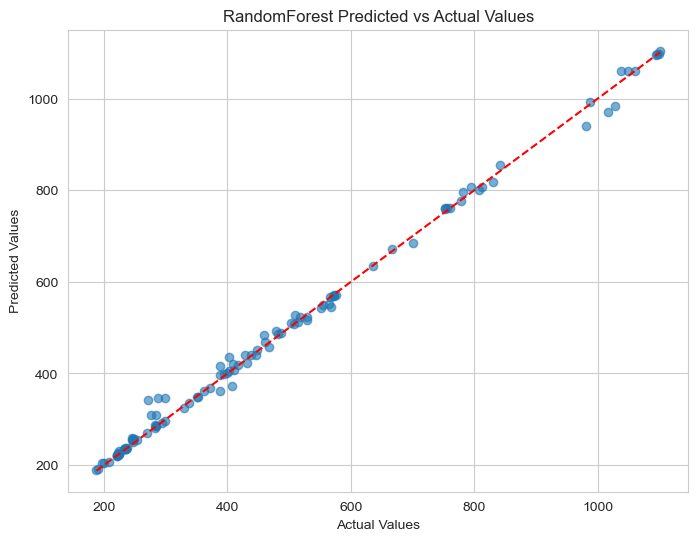

Selected Features and Coefficients:
Feature: SHA_fnf, Coefficient: -269.06392225819707
Feature: SHA_inf, Coefficient: 40.73964931057167
Feature: SHA_otf, Coefficient: 28.674422751740014
Feature: SHA_gains, Coefficient: 15.795249563381992
Feature: ORO_inf, Coefficient: -4.757200180254584
Feature: ORO_otf, Coefficient: 50.51730116731008
Feature: ORO_precip, Coefficient: 14.582159448889115
Feature: ORO_gains, Coefficient: -88.30050462163754
Feature: YRS_fnf, Coefficient: -45.01252129717353
Feature: YRS_storage, Coefficient: 83.39257252945664
Feature: YRS_precip, Coefficient: 18.426433545480236
Feature: FOL_fnf, Coefficient: 143.32839064112315
Feature: MHB_precip, Coefficient: -10.837534774828068
Feature: PAR_snow, Coefficient: 17.471845535344826
Feature: PAR_evap, Coefficient: 2.152906403486591
Feature: PAR_precip, Coefficient: 49.43503260383463
Feature: PAR_gains, Coefficient: 10.375681112947127
Feature: NHG_storage, Coefficient: 2.5852384085490154
Feature: NHG_evap, Coefficient: 5.57263

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
merged_df = merged_df.dropna() 
X = merged_df.drop(["NQH2O", "6_Month_Forward_Avg", 'datetime'], axis=1).values
y = merged_df["6_Month_Forward_Avg"].values
time = merged_df.index.values  
X_train, X_test, y_train, y_test, time_train,  _ = train_test_split(X, y, time, test_size=0.20, random_state=0)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit LassoCV model with more iterations and adjusted tolerance
lasso_cv = LassoCV(cv=5, max_iter=5000, tol=1e-4)
lasso_cv.fit(X_train_scaled, y_train)

# Feature selection
sfm = SelectFromModel(lasso_cv, prefit=True)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# Train a Random Forest Regressor using the selected features
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = model.predict(X_test_selected)
y_pred_train = model.predict(X_train_selected)


# Calculate R² and MSE
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"R² score: {r2_test}")
print(f"MSE_test: {mse_test}")
print(f"R² score_train: {r2_train}")
print(f"MSE_train: {mse_train}")

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RandomForest Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.show()

# Analyze selected features and their importance
selected_feature_indices = np.where(sfm.get_support())[0]
selected_features = merged_df.columns[selected_feature_indices]
coefficients = lasso_cv.coef_

# Print selected features and their coefficients
print("Selected Features and Coefficients:")
selected_features_with_coefficients = zip(selected_features, coefficients[selected_feature_indices])
for feature, coef in selected_features_with_coefficients:
    print(f"Feature: {feature}, Coefficient: {coef}")


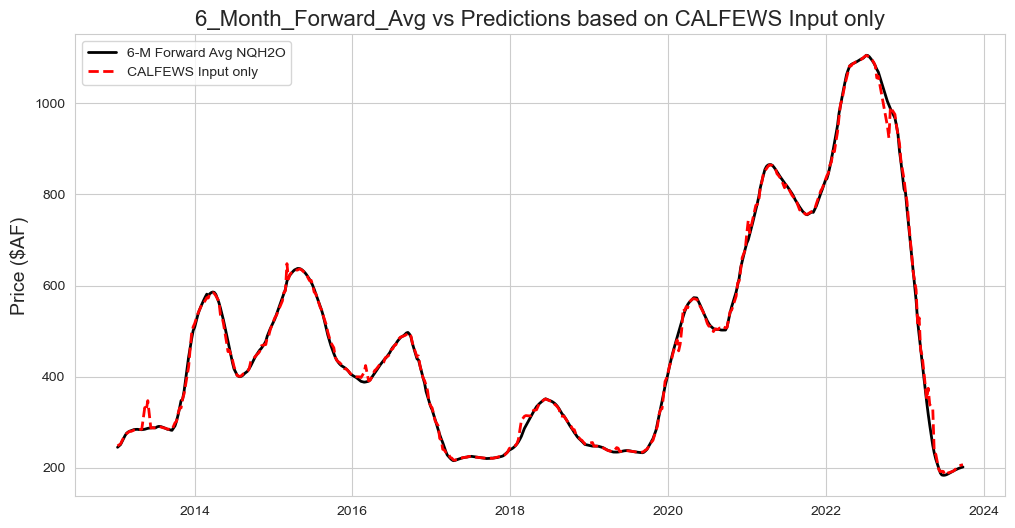

In [70]:
# Step 2: Sort the training data by time
sorted_indices = np.argsort(time_train)  # Get indices that would sort time_train
time_train_sorted = time_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]
y_pred_train_sorted = y_pred_train[sorted_indices]  # Ensure predictions are sorted too

#  Plot the sorted data
plt.figure(figsize=(12, 6))

# Plot original values (sorted)
plt.plot(time_train_sorted, y_train_sorted, label='6-M Forward Avg NQH2O', color='black', linewidth=2)
plt.plot(time_train_sorted, y_pred_train_sorted, label='CALFEWS Input only ', color='red', linestyle='--', linewidth=2)

# Add title and labels
plt.title('6_Month_Forward_Avg vs Predictions based on CALFEWS Input only', fontsize=16)
plt.ylabel('Price ($AF)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

In [85]:
# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cmap_cv = plt.cm.coolwarm
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.607e+04, tolerance: 7.327e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso Regression:
MSE: 351460.90058011224
R^2: -3.109012770211594

Random Forest Regressor:
MSE: 118931.03314052631
R^2: -0.39045092396412584


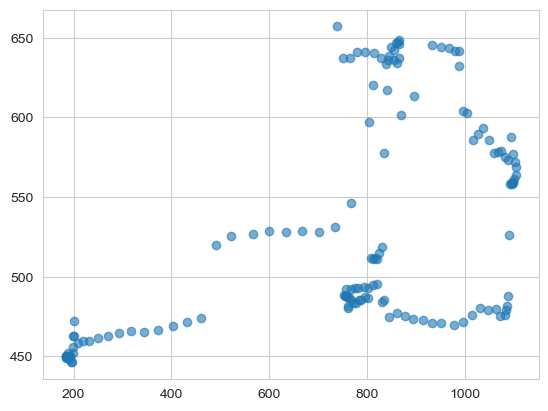

In [115]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
merged_df = merged_df.dropna() 
X = merged_df.drop(["NQH2O", "6_Month_Forward_Avg", 'datetime'], axis=1).values
y = merged_df["6_Month_Forward_Avg"].values
time = merged_df.index.values  

# Time series cross-validation splits
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)
train_indices, test_indices = [], []
for train_index, test_index in tscv.split(X):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Take the last split for actual evaluation
train_index = train_indices[-1]
test_index = test_indices[-1]

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


## Lasso Regression
lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

## Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Output results
print("Lasso Regression:")
print(f"MSE: {mse_lasso}")
print(f"R^2: {r2_lasso}")

print("\nRandom Forest Regressor:")
print(f"MSE: {mse_rf}")
print(f"R^2: {r2_rf}")
plt.scatter(y_test, y_pred_rf, alpha=0.6)

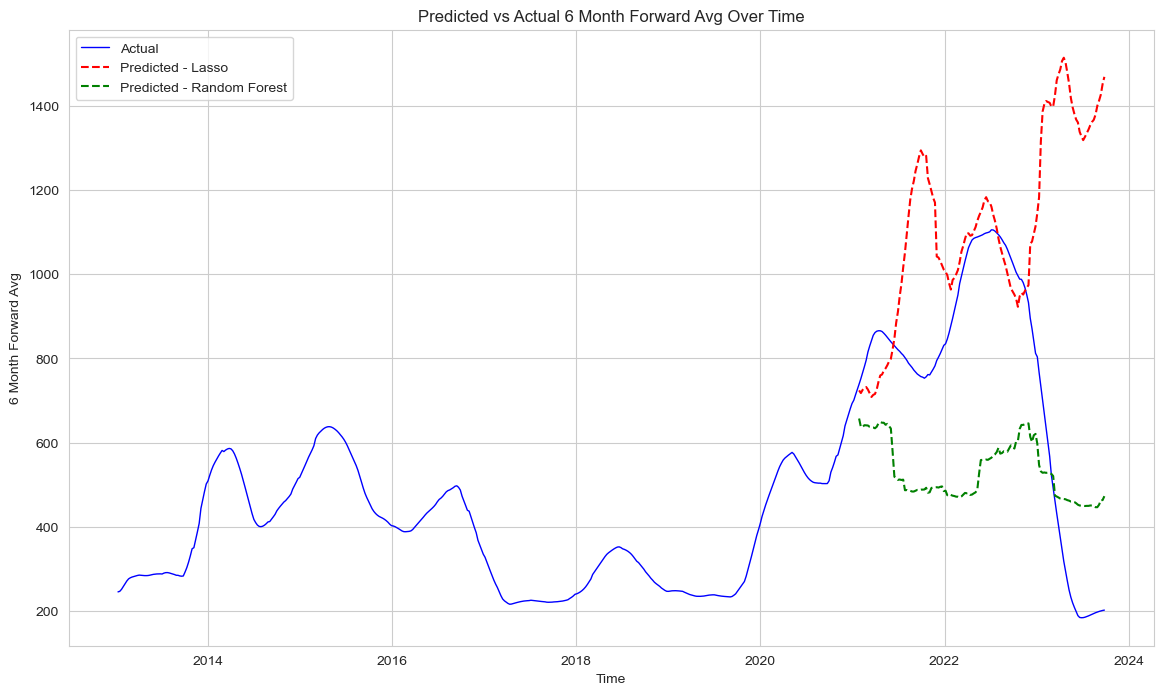

In [116]:
# Convert test time indices to actual datetime index values for plotting
time_test = time[test_index]

# Plot the full time series
plt.figure(figsize=(14, 8))

# Actual values
plt.plot(time, y, label="Actual", color='blue', linewidth=1)

# Predictions
plt.plot(time_test, y_pred_lasso, label="Predicted - Lasso", color='red', linestyle='--')
plt.plot(time_test, y_pred_rf, label="Predicted - Random Forest", color='green', linestyle='--')

plt.xlabel("Time")
plt.ylabel("6 Month Forward Avg")
plt.title("Predicted vs Actual 6 Month Forward Avg Over Time")
plt.legend()
plt.show()

